## A basic example of a Generative Adversarial Network.  Based in part on lecture from pydata 2018 in NYC.

In [1]:
# !brew install graphviz
# !pip install -q pydot

In [163]:
# Import modules
from __future__ import division

import keras
import keras.backend as K
import numpy as np
import functools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from IPython.display import SVG
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.callbacks import History 
from sklearn.metrics import classification_report, confusion_matrix
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [227]:
# set pandas options
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

In [254]:
# Set plot style
plt.style.use('dark_background')

In [157]:
def plot_model(model):
    return SVG(keras.utils.vis_utils.model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [255]:
def history_plot(history, validation=True, figsize_=(20,10)):
    """Plot network metric history for traning and validation sets"""
    df = pd.DataFrame(history.history)
    num_epochs = df.shape[0]
    
    # Set figure size option
    # plt.rcParams['figure.figsize'] = figsize_
    # Why do I need to reset this everytime?
    plt.style.use('dark_background')
    plt.figure(figsize=figsize_)
    metrics_ = [x for x in df.columns.tolist() if 'val' not in x]
    num_metrics = len(metrics_)
    
    for i in range(0, num_metrics):
        plt.subplot(int(round(num_metrics/2)), 2, i+1)
        plt.plot(df[metrics_[i]].values, 'r')
        if validation:
            validation_metric = 'val_' + metrics_[i]
            plt.plot(df[validation_metric].values, 'g')
        plt.xticks(np.arange(0, num_epochs+1, 1.0))
        plt.xlabel("Num of Epochs")
        plt.ylabel(metrics_[i])
        plt.title("Training {0} vs Validation {1}".format(metrics_[i], metrics_[i]))
        plt.legend(['train','validation'])
    plt.tight_layout()
    plt.show()

In [176]:
def make_confusion_matrix(classifier_, x_test, y_test, figsize_=(20,10)):
    """Make a confusion matrix"""
    Y_pred = classifier_.predict(x_test)
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Compute the confusion matrix and store as a DataFrame
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm)
    
    plt.figure(figsize=figsize_)
    # Set label font size
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})

# Load data
* First, we'll use the cifar 10 data set.  
* It has 60,000 32x32 colour images representing 10 classes: 
    * airplanes, cars, birds, cats, deer, dogs, frogs, horses, shops, and trucks
* Each class has 6,000 images

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [7]:
# What is the distribution in pixel values?
x_train.max()

255

In [8]:
x_train.min()

0

In [9]:
x_test.max()

255

In [10]:
x_test.min()

0

In [11]:
# What are the unique classes? Are they the same in the training and testing set?
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [12]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Text(0.5,1,'Count of target classes in training set')

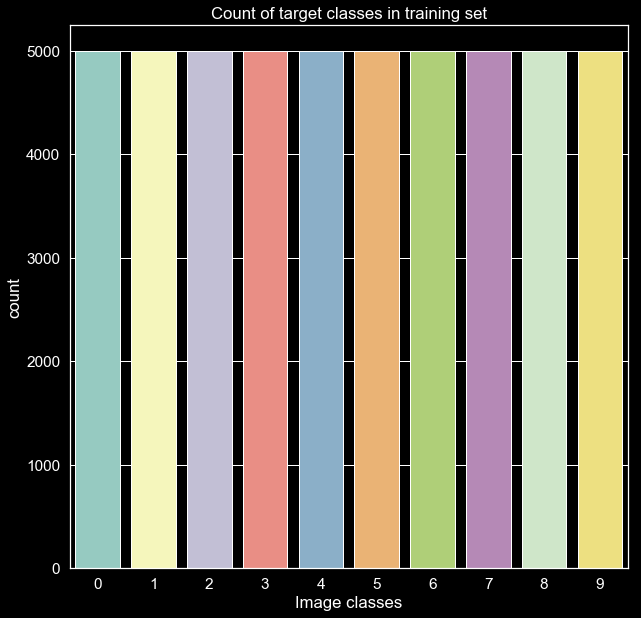

In [166]:
# So they are the same (all classes are reprented in the testing and training sets.)  Are the distributions the same-ish?
plt.figure(figsize=(10,10))
sns.countplot(x=0, data=pd.DataFrame(y_train))
plt.xlabel('Image classes')
plt.title('Count of target classes in training set')

Text(0.5,1,'Count of target classes in testing set')

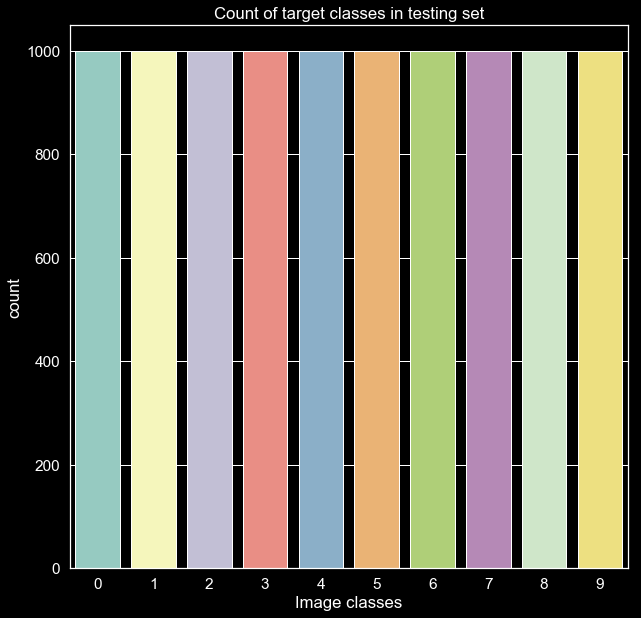

In [167]:
plt.figure(figsize=(10,10))
sns.countplot(x=0, data=pd.DataFrame(y_test))
plt.xlabel('Image classes')
plt.title('Count of target classes in testing set')

In [15]:
# So the distributions of the target classes looks the same in both the training and testing sets.  

In [16]:
# Now, we'll scale the pixel values to be between -1 and 1.  
x_train = (2/(x_train.max()))*x_train - 1
x_test = (2/(x_test.max()))*x_test - 1

In [17]:
print('training set pixel values scaled to {0} and {1}').format(np.min(x_train), np.max(x_train))
print('\n')
print('testing set pixel values scaled to {0} and {1}').format(np.min(x_test), np.max(x_test))

training set pixel values scaled to -1.0 and 1.0


testing set pixel values scaled to -1.0 and 1.0


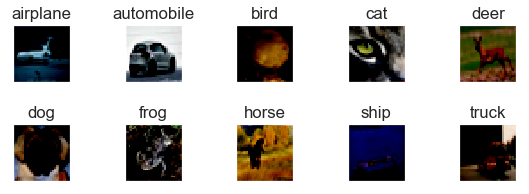

In [268]:
# Plot a few of the images at random
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship', 'truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    # im = np.transpose(features_idx[img_num,::],(1,2,0))
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.tight_layout()
plt.show()

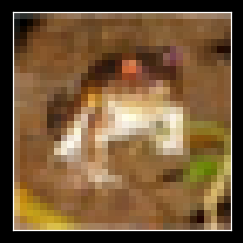

In [427]:
fig = imshow((x_train[0,...]+1)/2)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

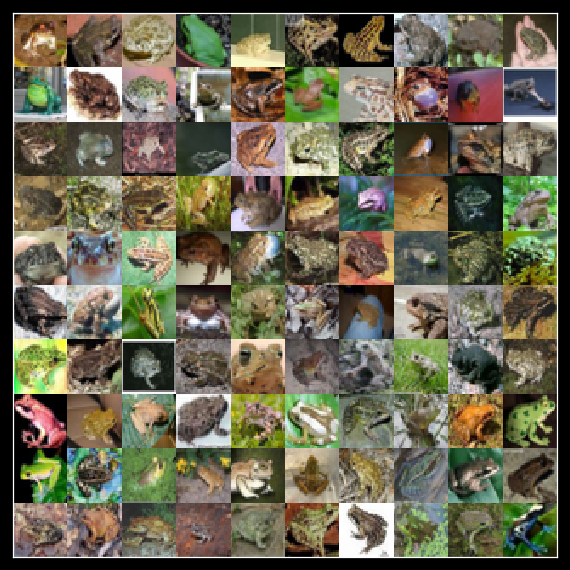

In [428]:
# Here's the frogs

sample_side = 10
im_size = 32

frog_i,_ = np.where(y_train==6)
frog_x = x_train[frog_i,...]
frog_x = frog_x[:sample_side*sample_side]

# Rescale images 0 - 255
frog_x = (frog_x+1)/2

frog_x = frog_x.reshape(sample_side,sample_side*im_size,im_size,3)
frog_x = frog_x.transpose((0,2,1,3))
frog_x = frog_x.reshape(sample_side*im_size,sample_side*im_size,3)
frog_x = frog_x.transpose((1,0,2))

figsize(10, 10)

fig = imshow(frog_x)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

# Convolutional neural network
* To start, let's try building a CNN classifier on this data.

In [41]:
# For convenience, use functools partial to define a basic convolutional layer which we'll be using several times. We'll use a 2D layer, as the inputs are 2D.
# filters: the dimensionality of the output subspace. We should try changing this.  
# kernel_size: setting this to 3 is equivalent to setting the height and width of the convolutional window to be 3x3
# strides: setting this to2 is equivalent to setting the strides of the convolution along the height and width to be 2x2
# padding: same means padding the input such that the output has the same length as the original input
conv = functools.partial(keras.layers.Conv2D, filters=50, kernel_size=3, strides=2, activation="relu", padding="same")

In [42]:
num_classes = len(np.unique(y_train))

In [43]:
# Initialize the model
classifier_cnn = keras.Sequential()

In [44]:
# The images in the training (and testing set) have dimensions:
x_train.shape[1:]

(32, 32, 3)

In [45]:
# The images are 32x32 pixels, with 3 colour channels in red, green, and blue.  The input layer needs to reflect this.  

In [46]:
# Add the input layer.
classifier_cnn.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))

In [47]:
# Add convolutional layers.  We'll try 3 convolutional layers.  What happens if we change this?
classifier_cnn.add(conv())
classifier_cnn.add(conv())
classifier_cnn.add(conv())

In [48]:
# After the first convolutional layer, the expected output shape should be (16, 16, 50), since we're using a stride of 2 in width and height, and the number of output filters
# is set to 50.  After the second conv layer, the output shape should be (8, 8, 50).  Finally, the third conv layer should result in an output of (4, 4, 50).

In [49]:
# Add a layer to flatten the vectors going through here
classifier_cnn.add(keras.layers.Flatten())

In [50]:
# To get the output classes, we'll want to get down to a 10 dimensional output vector.  We'll get the output out of a dense layer by first flattening the output of the last
# conv layer.  The results should be a vector of length 4x4x50 = 800.  This goes into a densely connected layer with a softmax activation function to get predicted classes.

In [51]:
# Add a dense layer for the output with softmax activation
classifier_cnn.add(keras.layers.Dense(num_classes, activation="softmax"))

In [52]:
classifier_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 50)        1400      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 50)          22550     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 50)          22550     
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8010      
Total params: 54,510
Trainable params: 54,510
Non-trainable params: 0
_________________________________________________________________


In [53]:
# The summary above gives the expected dimensional outputs at each layer.

In [54]:
# We can visualize the network architecture
sequential_model_to_ascii_printout(classifier_cnn)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
          InputLayer     |   -------------------         0     0.0%
                       #####     32   32    3
              Conv2D    \|/  -------------------      1400     2.0%
                relu   #####     16   16   50
              Conv2D    \|/  -------------------     22550    41.0%
                relu   #####      8    8   50
              Conv2D    \|/  -------------------     22550    41.0%
                relu   #####      4    4   50
             Flatten   ||||| -------------------         0     0.0%
                       #####         800
               Dense   XXXXX -------------------      8010    14.0%
             softmax   #####          10


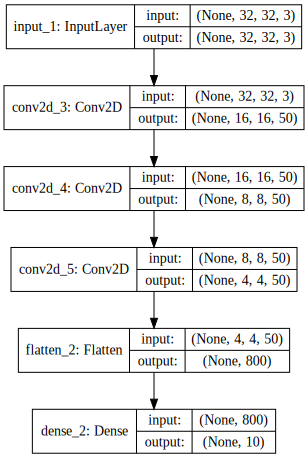

In [55]:
# Here's a nicer plot
plot_model(classifier_cnn)

In [56]:
# Compile the model. We use sparse_categorical_crossentropy as our targets are integers (if the target was hot encoded, we could use categorical_crossentropy, but we would
# absolutely have to hot-encode the target variable first).  The metric will be categorical accuracy.
classifier_cnn.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['acc'])

In [58]:
# Before fitting, define the history object for the callbacks.
history_cnn = History()

In [59]:
# Fit the model.
classifier_cnn.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=10, callbacks=[history_cnn])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 23s 456us/step - loss: 1.4720 - acc: 0.4750 - val_loss: 1.2344 - val_acc: 0.5559
Epoch 2/10
50000/50000 [==============================] - 20s 392us/step - loss: 1.1482 - acc: 0.5910 - val_loss: 1.0893 - val_acc: 0.6078
Epoch 3/10
50000/50000 [==============================] - 23s 454us/step - loss: 1.0119 - acc: 0.6424 - val_loss: 1.0536 - val_acc: 0.6264
Epoch 4/10
50000/50000 [==============================] - 24s 473us/step - loss: 0.9205 - acc: 0.6769 - val_loss: 0.9771 - val_acc: 0.6547
Epoch 5/10
50000/50000 [==============================] - 23s 464us/step - loss: 0.8478 - acc: 0.7029 - val_loss: 0.9512 - val_acc: 0.6655
Epoch 6/10
50000/50000 [==============================] - 24s 480us/step - loss: 0.7893 - acc: 0.7218 - val_loss: 0.9599 - val_acc: 0.6723
Epoch 7/10
50000/50000 [==============================] - 23s 454us/step - loss: 0.7385 - acc: 0.7380 - val_loss: 0.

In [60]:
score_cnn = classifier_cnn.evaluate(x_test, y_test, verbose=0)

In [61]:
print('Test loss: {0}'.format(score_cnn[0]))

Test loss: 1.005784235


In [62]:
print('Test accuracy: {0}'.format(score_cnn[1]))

Test accuracy: 0.6729


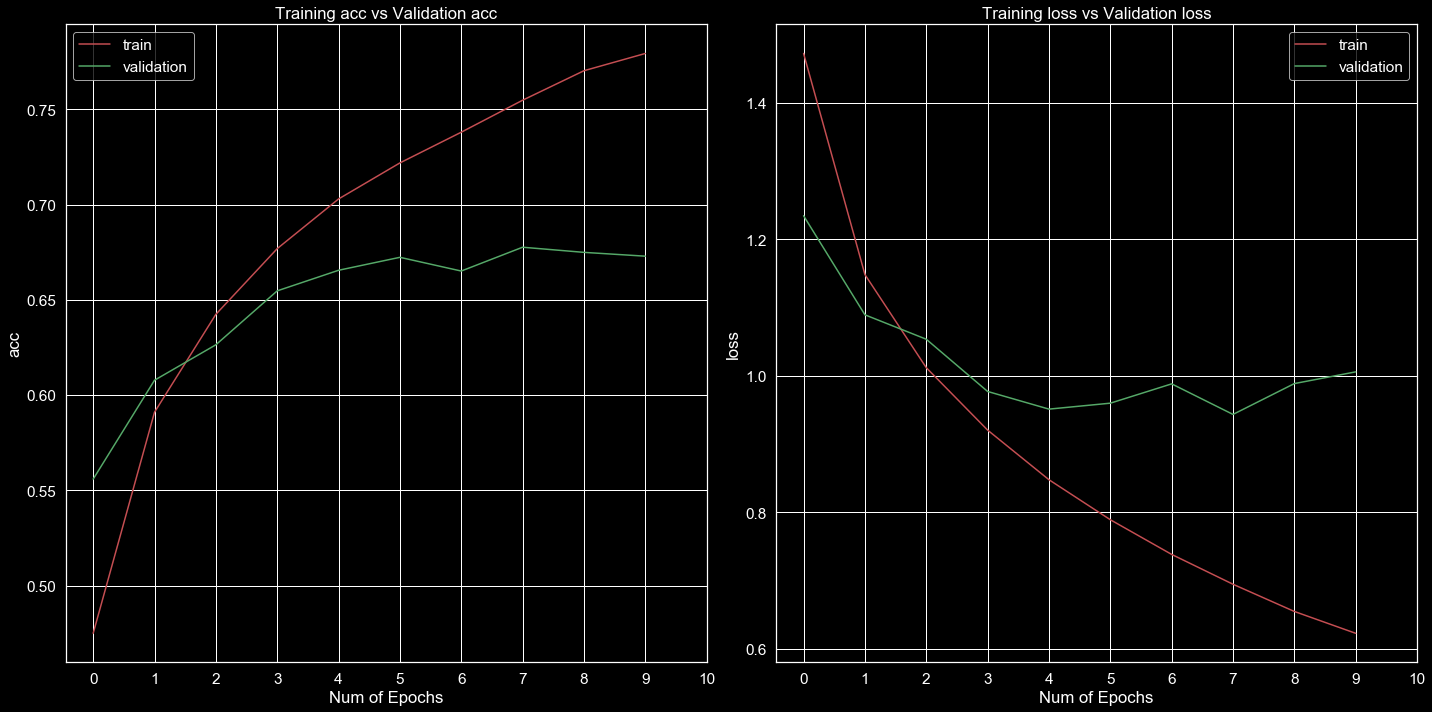

In [169]:
history_plot(history=history_cnn, validation=True, figsize_=(20,10))

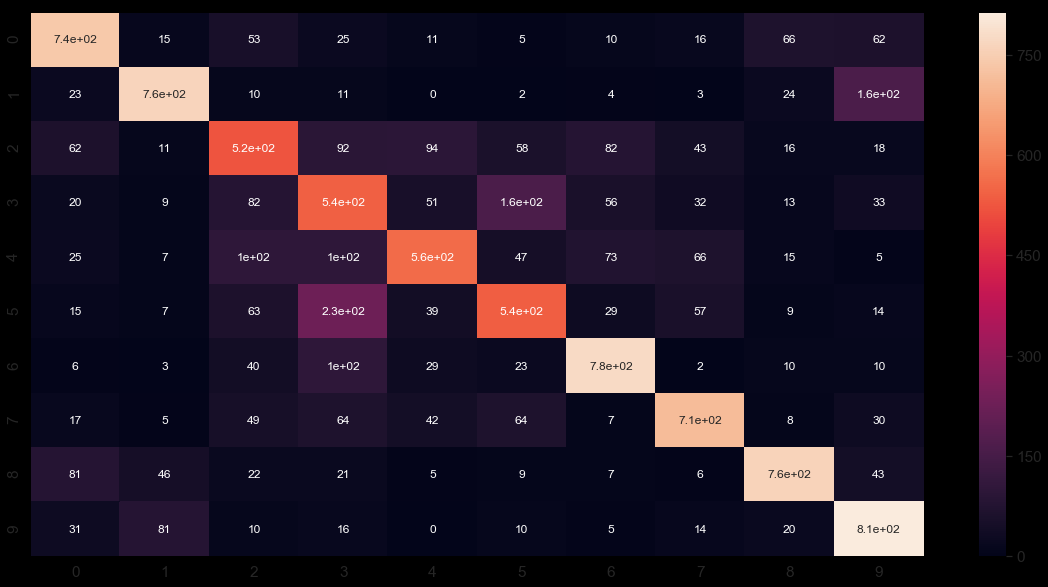

In [175]:
make_confusion_matrix(classifier_=classifier_cnn, x_test=x_test, y_test=y_test, figsize_=(20,10))

In [44]:
# Pretty bad. Can we improve this?

## Modify the Convolutional neural network architecture

In [177]:
# Initialize a sequential model.
classifier_cnn2 = keras.Sequential()

In [178]:
# Add an input convolutional layer.
# Input is still (32, 32, 3) dimensional.  
classifier_cnn2.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', input_shape=x_train.shape[1:], padding="same"))

In [179]:
# We did a stride size of 1 height and 1 width, so add a pooling layer to down-sample the image data in the next layers.
# After the first layer, the output dimensions should be (32, 32, 32).  We'll pool here to reduce the dimensionality at the next pass.  Using a stride of (2, 2),
# The expected output should be (16, 16, 32)
classifier_cnn2.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [180]:
# Add another convolutional layer.  The expected output dimension is now (16, 16, 64)
classifier_cnn2.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', padding="same"))

In [181]:
# Add another pooling layer since we did one stride in the above convolutional layer. Pooling again, so the expected output dimension is now (8, 8, 32)
classifier_cnn2.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(4,4)))

In [182]:
# Add a flatten layer. Flattening should result in an output vector of 4x4x32 = 512 dimensions.
classifier_cnn2.add(keras.layers.Flatten())

In [183]:
# Output to a dense layer. Use softmax activation to get the predicted class labels. The dense layer should reduce the output for a 10 dimensional vector.
classifier_cnn2.add(keras.layers.Dense(num_classes, activation='softmax'))

In [184]:
classifier_cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 15,274
Trainable params: 15,274
Non-trainable params: 0
_________________________________________________________________


In [185]:
sequential_model_to_ascii_printout(classifier_cnn2)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
              Conv2D    \|/  -------------------       896     5.0%
                relu   #####     32   32   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     16   16   32
              Conv2D    \|/  -------------------      9248    60.0%
                relu   #####     16   16   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   32
             Flatten   ||||| -------------------         0     0.0%
                       #####         512
               Dense   XXXXX -------------------      5130    33.0%
             softmax   #####          10


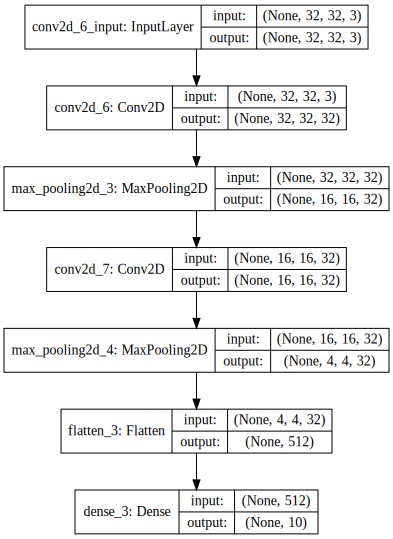

In [186]:
plot_model(classifier_cnn2)

In [189]:
classifier_cnn2.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['acc'])

In [190]:
# Before fitting, define the history object for the callbacks.
history_cnn2 = History()

In [ ]:
# Fit the model.
classifier_cnn2.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=10, callbacks=[history_cnn2])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 38s 752us/step - loss: 1.4874 - acc: 0.4718 - val_loss: 1.2971 - val_acc: 0.5352
Epoch 2/10
50000/50000 [==============================] - 36s 722us/step - loss: 1.2054 - acc: 0.5770 - val_loss: 1.1718 - val_acc: 0.5822
Epoch 3/10
46464/50000 [==========================>...] - ETA: 2s - loss: 1.0909 - acc: 0.6162

In [192]:
score_cnn2 = classifier_cnn2.evaluate(x_test, y_test, verbose=0)

In [193]:
print('Test loss: {0}'.format(score_cnn2[0]))

Test loss: 0.935028290844


In [194]:
print('Test accuracy: {0}'.format(score_cnn2[1]))

Test accuracy: 0.6786


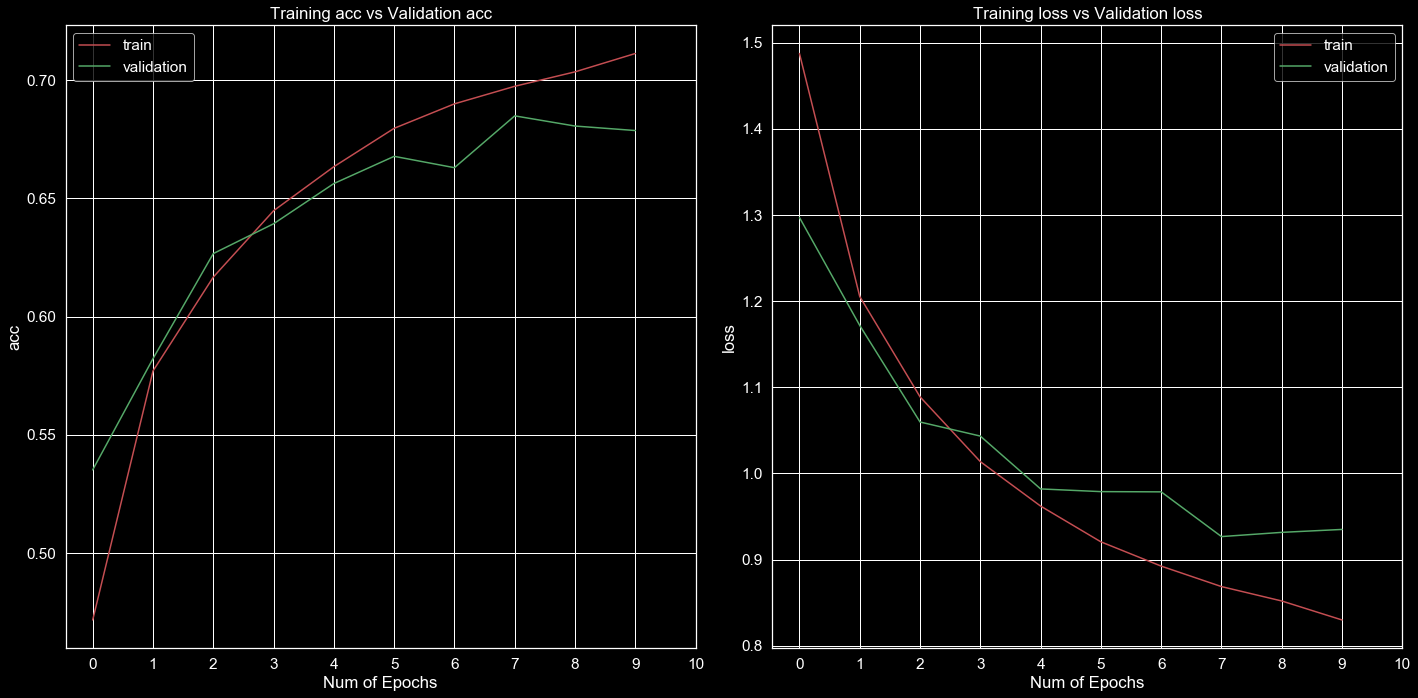

In [197]:
history_plot(history=history_cnn2, validation=True, figsize_=(20,10))

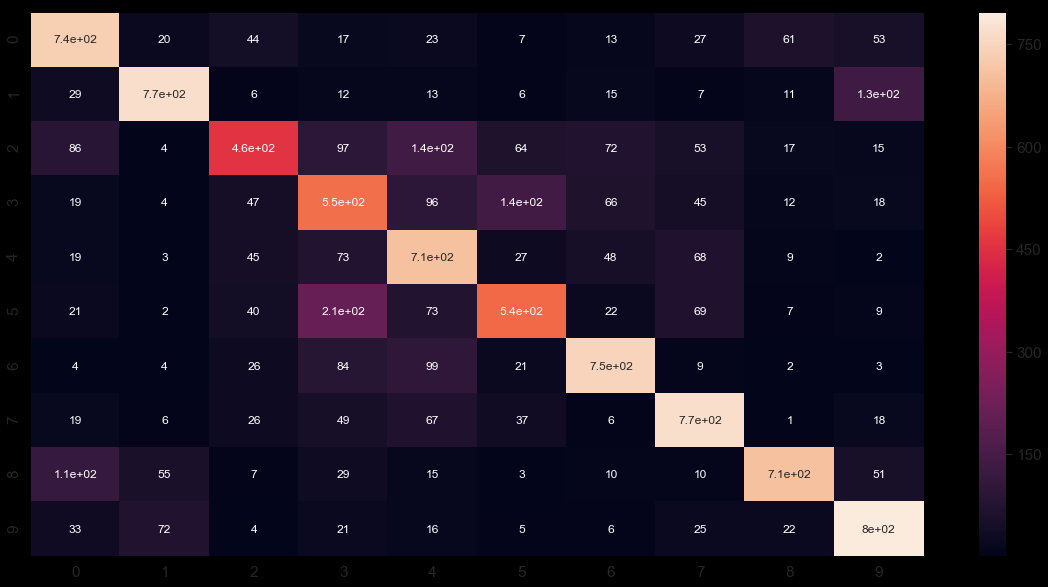

In [198]:
make_confusion_matrix(classifier_=classifier_cnn2, x_test=x_test, y_test=y_test, figsize_=(20,10))

## Add dropout layers to see if this helps.
* we might just need more epochs
* Also adjust weight initialization.

In [322]:
# Initialize a sequential model.
classifier_cnn3 = keras.Sequential()

In [323]:
# Add the input layer.
classifier_cnn3.add(keras.layers.InputLayer(input_shape=x_train.shape[1:]))

In [324]:
# Add an input convolutional layer.
# Input dimemsions here are (32, 32, 3).  Output should be (16, 16, 50)
classifier_cnn3.add(keras.layers.Conv2D(filters=50, 
                                        kernel_size=3, 
                                        strides=2, 
                                        activation='relu', 
                                        padding="same", 
                                        kernel_initializer=keras.initializers.glorot_normal(), 
                                        bias_initializer=keras.initializers.RandomNormal()))

In [325]:
# Expected output dimensions (8, 8, 50)
classifier_cnn3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [326]:
# Add a dropout layer
classifier_cnn3.add(keras.layers.Dropout(rate=0.25))

In [327]:
# Add another covolutional layer
# Expected output dimensions (4, 4, 50)
classifier_cnn3.add(keras.layers.Conv2D(filters=50, kernel_size=3, strides=1, activation='relu', padding='same'))

In [328]:
# Expected output dimensions (2, 2, 50)
classifier_cnn3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [329]:
# Add another dropout layer
classifier_cnn3.add(keras.layers.Dropout(rate=0.25))

In [330]:
# Add another convolutional layer
# expected output dimensions (2, 2, 50)
classifier_cnn3.add(keras.layers.Conv2D(filters=50, kernel_size=3, strides=1, activation='relu', padding='same'))

In [331]:
# Flatten
classifier_cnn3.add(keras.layers.Flatten())

In [332]:
classifier_cnn3.add(keras.layers.Dropout(rate=0.5))

In [333]:
# Expected output dimension: 10 dimensional vector.
classifier_cnn3.add(keras.layers.Dense(num_classes, activation='softmax'))

In [334]:
classifier_cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 50)        1400      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 50)          22550     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 50)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 4, 4, 50)          0         
__________

In [335]:
sequential_model_to_ascii_printout(classifier_cnn3)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
          InputLayer     |   -------------------         0     0.0%
                       #####     32   32    3
              Conv2D    \|/  -------------------      1400     2.0%
                relu   #####     16   16   50
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      8    8   50
             Dropout    | || -------------------         0     0.0%
                       #####      8    8   50
              Conv2D    \|/  -------------------     22550    41.0%
                relu   #####      8    8   50
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   50
             Dropout    | || -------------------         0     0.0%
                       #####      4    4   50
              Conv2D    \|/  -------------------     22550    41.0%
              

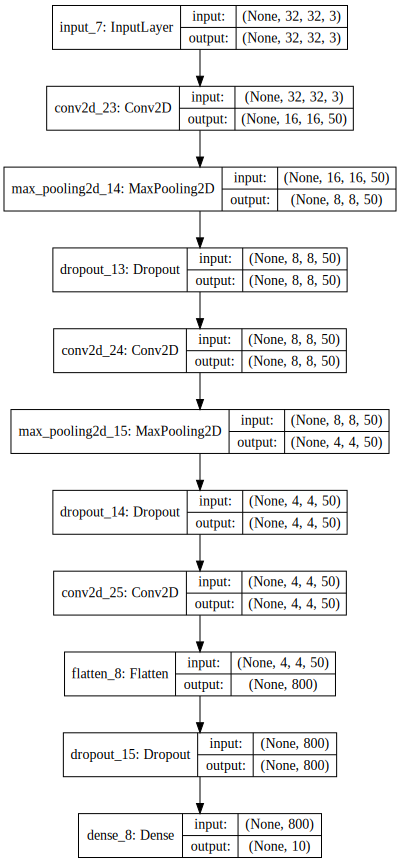

In [336]:
plot_model(classifier_cnn3)

In [337]:
classifier_cnn3.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['acc'])

In [338]:
# Before fitting, define the history object for the callbacks.
history_cnn3 = History()

In [339]:
# Fit the model.
classifier_cnn3.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=10, callbacks=[history_cnn3])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 24s 474us/step - loss: 1.6006 - acc: 0.4126 - val_loss: 1.2712 - val_acc: 0.5454
Epoch 2/10
50000/50000 [==============================] - 21s 425us/step - loss: 1.3123 - acc: 0.5256 - val_loss: 1.1392 - val_acc: 0.6028
Epoch 3/10
50000/50000 [==============================] - 21s 427us/step - loss: 1.2093 - acc: 0.5682 - val_loss: 1.0448 - val_acc: 0.6306
Epoch 4/10
50000/50000 [==============================] - 21s 429us/step - loss: 1.1376 - acc: 0.5938 - val_loss: 1.0073 - val_acc: 0.6463
Epoch 5/10
50000/50000 [==============================] - 22s 435us/step - loss: 1.1027 - acc: 0.6073 - val_loss: 0.9365 - val_acc: 0.6692
Epoch 6/10
50000/50000 [==============================] - 22s 437us/step - loss: 1.0669 - acc: 0.6216 - val_loss: 0.9511 - val_acc: 0.6751
Epoch 7/10
50000/50000 [==============================] - 22s 443us/step - loss: 1.0420 - acc: 0.6311 - val_loss: 0.

In [318]:
score_cnn3 = classifier_cnn3.evaluate(x_test, y_test, verbose=0)

In [319]:
print('Test loss: {0}'.format(score_cnn3[0]))

Test loss: 1.03662308388


In [320]:
print('Test accuracy: {0}'.format(score_cnn3[1]))

Test accuracy: 0.626


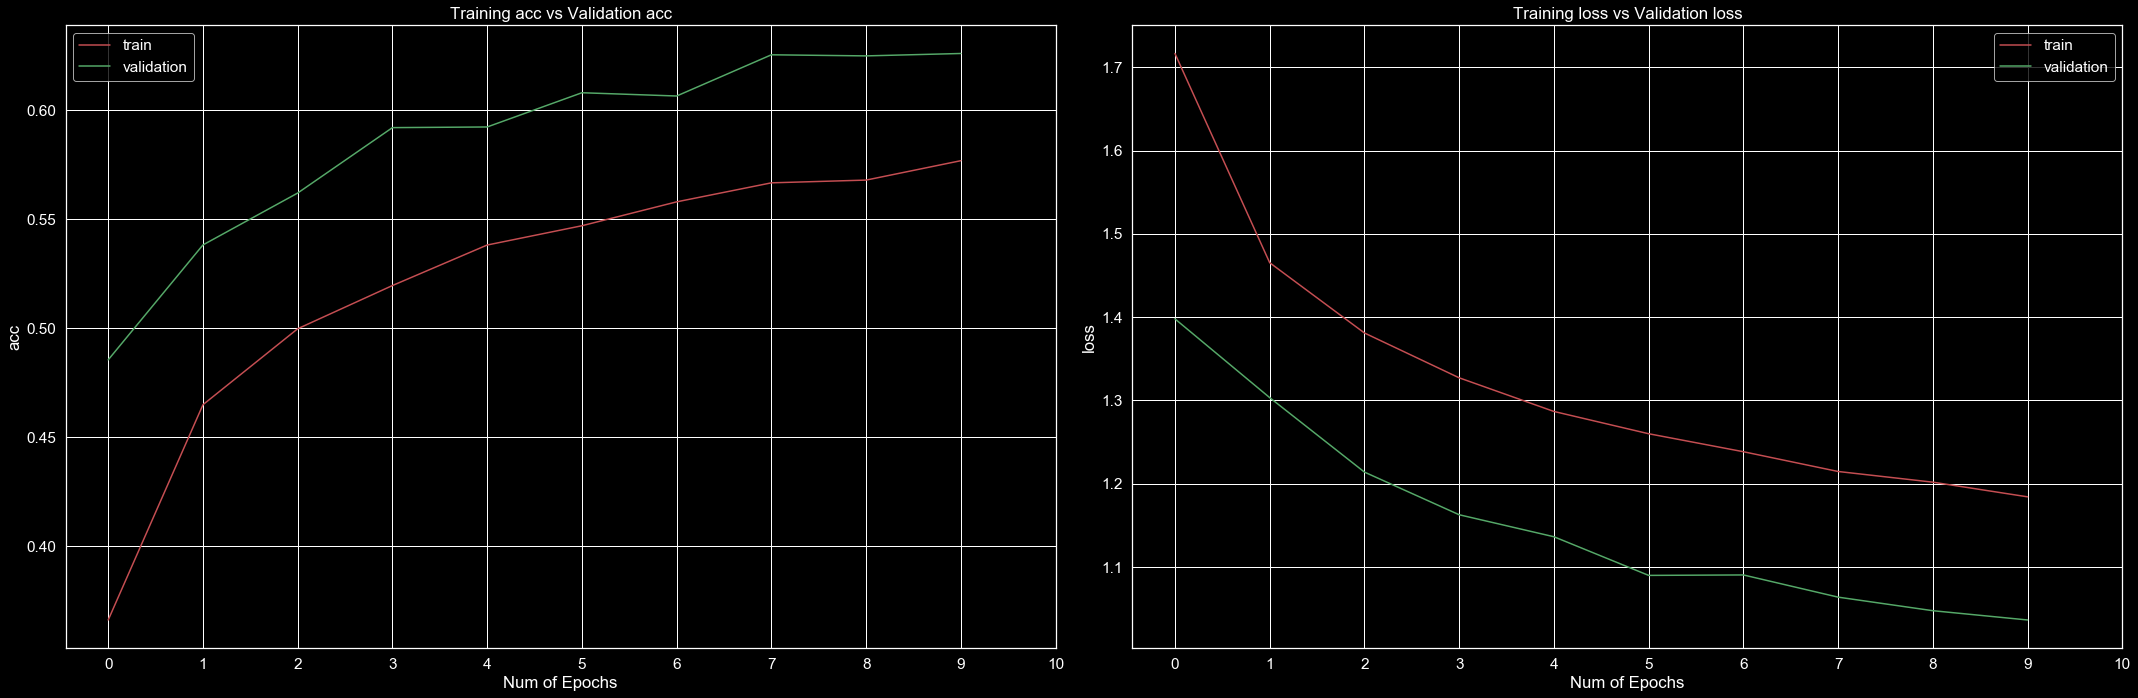

In [321]:
history_plot(history=history_cnn3, validation=True, figsize_=(30,10))

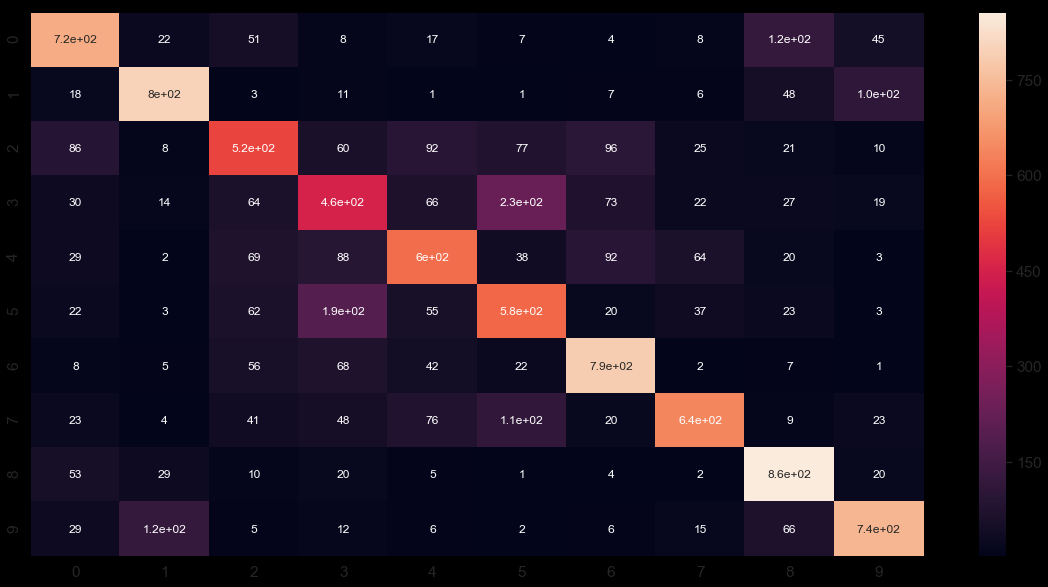

In [291]:
make_confusion_matrix(classifier_=classifier_cnn3, x_test=x_test, y_test=y_test, figsize_=(20,10))

In [344]:
# Getting better...still looks like we could try a few additional epochs.  We could also condense the max pooling operations by using different strides in the convolution layers.
# Would also be worth trying batch normalization layers to see if that helps.  Let's move on to a GAN implementation.

# Try a Generative Adversarial Network

In [295]:
# We need to build a discriminator and a generator.  The generator should learn how to model the distribution of the training data.  That is, the discriminator should learn
# the entire world of possibilities tha the training data came from.  This is what distinguishes this approach from an Autoencoder.

In [340]:
# Define a partial activation function for convenience
lrelu = functools.partial(K.relu, alpha=0.1)
# Use this parameter to define the input shape of the generator (which takes noise and generates images)
z_len = 100

## Define the discriminator model

In [341]:
disc_model = keras.Sequential()

In [342]:
# Add an input layer. The images have dimensions (32, 32, 3)
disc_model.add(keras.layers.InputLayer(input_shape=(32, 32, 3)))

In [343]:
# Add a convolutional layer. Expected output dimensions are (16, 16, 50)
disc_model.add(keras.layers.Conv2D(filters=50, 
                                   kernel_size=3, 
                                   strides=2, 
                                   padding='same', 
                                   activation=lrelu,
                                   kernel_initializer=keras.initializers.glorot_normal(),
                                   bias_initializer=keras.initializers.RandomNormal()))

In [345]:
# Add a batch normalization layer. This will normalize the input to the activation function in the next layer, pushing us into the linear section of the activation function.
# How much of an effect does this really have?
disc_model.add(keras.layers.BatchNormalization())

In [346]:
# Add another convolutional layer.  The expected output dimension will now be (8, 8, 50)
disc_model.add(keras.layers.Conv2D(filters=50, kernel_size=3, strides=2, padding='same', activation='relu'))

In [347]:
# More batch normalization
disc_model.add(keras.layers.BatchNormalization())

In [349]:
# Another convolutional layer. The expected output dimensions are (4, 4, 50)
disc_model.add(keras.layers.Conv2D(filters=50, kernel_size=3, strides=2, padding='same', activation='relu'))

In [350]:
# Finally, one last batch normalization before flattening and sending to a dense layer for final output.
disc_model.add(keras.layers.BatchNormalization())

In [351]:
# Flatten. The output should be an 800 dimensional vector
disc_model.add(keras.layers.Flatten())

In [352]:
# Dense layer for output. I want a 1 dimensional vector output
disc_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [353]:
disc_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 50)        1400      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 50)        200       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 50)          22550     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 50)          200       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 4, 4, 50)          22550     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 50)          200       
__________

In [354]:
sequential_model_to_ascii_printout(disc_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
          InputLayer     |   -------------------         0     0.0%
                       #####     32   32    3
              Conv2D    \|/  -------------------      1400     2.0%
                       #####     16   16   50
  BatchNormalization    Î¼|Ï  -------------------       200     0.0%
                       #####     16   16   50
              Conv2D    \|/  -------------------     22550    47.0%
                relu   #####      8    8   50
  BatchNormalization    Î¼|Ï  -------------------       200     0.0%
                       #####      8    8   50
              Conv2D    \|/  -------------------     22550    47.0%
                relu   #####      4    4   50
  BatchNormalization    Î¼|Ï  -------------------       200     0.0%
                       #####      4    4   50
             Flatten   ||||| -------------------         0     0.0%
        

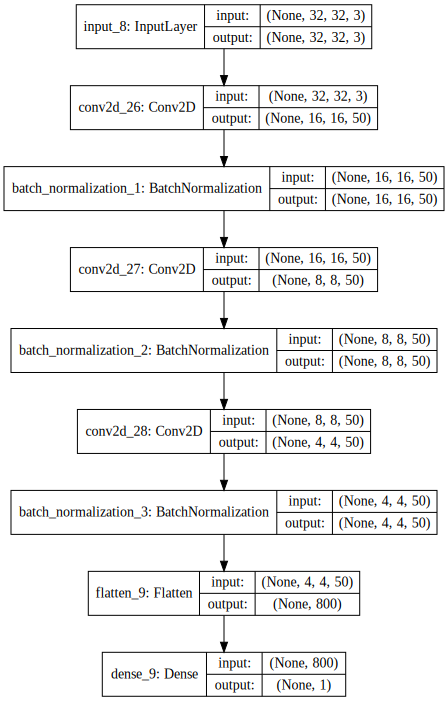

In [355]:
plot_model(disc_model)

## Define the generator model

In [391]:
gen_model = keras.Sequential()

In [392]:
# Input layer.  It takes noise.  We defined a parameter above for the shape of the noise.  We might want to play around with this a bit. 
gen_model.add(keras.layers.InputLayer(input_shape=(z_len, )))

In [393]:
# Add a dense layer. This is the same output dimensions as the flattening layer in the discriminator model
gen_model.add(keras.layers.Dense(50 * 4 * 4, activation='relu'))

In [394]:
# Reshape to have the same dimensionality as last convolutional layer in the discriminator model
gen_model.add(keras.layers.Reshape((4, 4, 50)))

In [395]:
# Batch normalization layer
gen_model.add(keras.layers.BatchNormalization())

In [396]:
# Add a 2D upsampling layer (do I need to do this?)
gen_model.add(keras.layers.UpSampling2D())

In [397]:
# Add a convolutional layer. The expected ouput dimensions are (4, 4, 50)
gen_model.add(keras.layers.Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu'))

In [398]:
# Batch normalize
gen_model.add(keras.layers.BatchNormalization())

In [399]:
# 2D up sample
gen_model.add(keras.layers.UpSampling2D())

In [400]:
# Another convolutional layer. The expected output dimensions should still be (4, 4, 50)
gen_model.add(keras.layers.Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu'))

In [401]:
# Batch normalization
gen_model.add(keras.layers.BatchNormalization())

In [402]:
# 2D up sampling
gen_model.add(keras.layers.UpSampling2D())

In [403]:
# A final convolutional layer to produce the generated input for the discriminator model.  This will use a tanh activation
# function (what if I used a relu?). The number of filters must be set to ensure that the output dimensions
gen_model.add(keras.layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation='tanh'))

In [404]:
# This is a big model...
gen_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 800)               80800     
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 50)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 50)          200       
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 50)          22550     
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 50)          200       
__________

In [405]:
sequential_model_to_ascii_printout(gen_model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         100
          InputLayer     |   -------------------         0     0.0%
                       #####         100
               Dense   XXXXX -------------------     80800    63.0%
                relu   #####         800
             Reshape     |   -------------------         0     0.0%
                       #####      4    4   50
  BatchNormalization    Î¼|Ï  -------------------       200     0.0%
                       #####      4    4   50
        UpSampling2D   AAAAA -------------------         0     0.0%
                       #####      8    8   50
              Conv2D    \|/  -------------------     22550    17.0%
                relu   #####      8    8   50
  BatchNormalization    Î¼|Ï  -------------------       200     0.0%
                       #####      8    8   50
        UpSampling2D   AAAAA -------------------         0     0.0%
                       ##

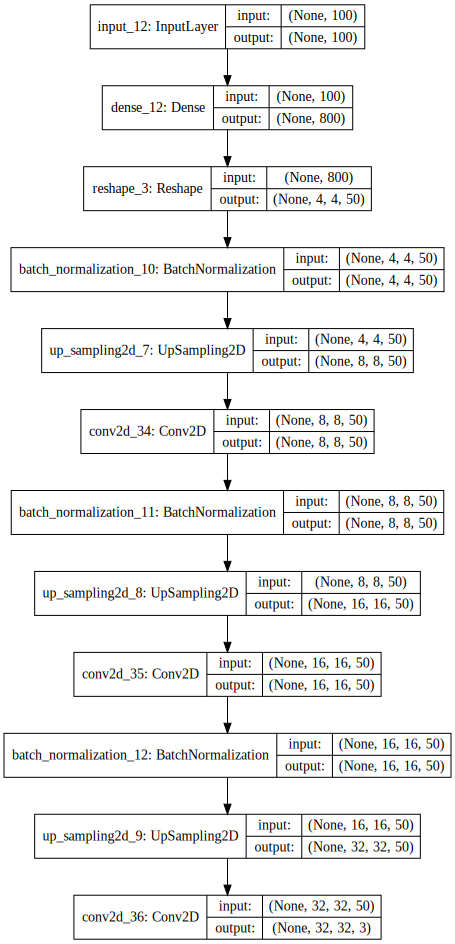

In [406]:
plot_model(gen_model)

## Prepare the discriminator and generator models for fitting

In [407]:
# Compile the discriminator.  Try modifying the optimizer and its parameters
disc_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

In [408]:
# The generator takes noise as input and generates images to pass to the discriminator, so we'll generate some noise.  Should be the same dimensions as the generator input layer.
z = keras.Input(shape=(z_len, ))

In [409]:
# generate the images
img = gen_model(z)

In [410]:
# We'll want to train the models together.  The combined model should only train the generator.
disc_model.trainable = False

In [412]:
# The discriminator model should take generated images and determine if they are valid.
valid = disc_model(img)

In [414]:
# Define the combined model.  It is the stacked generator and discriminator
comb = keras.Model(z, valid)

In [415]:
# Compile the combined model.  We want to train the generator to fool the discriminator.
comb.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

In [416]:
# Train in batches.
batch_size = 64

In [417]:
num_steps = x_train.shape[0] // batch_size

In [431]:
num_epochs = 1

In [421]:
valid_ = np.ones((batch_size, 1))

In [422]:
fake_ = np.zeros((batch_size, 1))

In [423]:
disc_loss_list = []
gen_loss_list = []

In [426]:
# Generate the noise sample.  We'll stick with the same set of noise to see how the generated images change.
noise_sample = np.random.normal(size=(10**2, z_len))

Starting eopch 0


<Figure size 720x720 with 0 Axes>

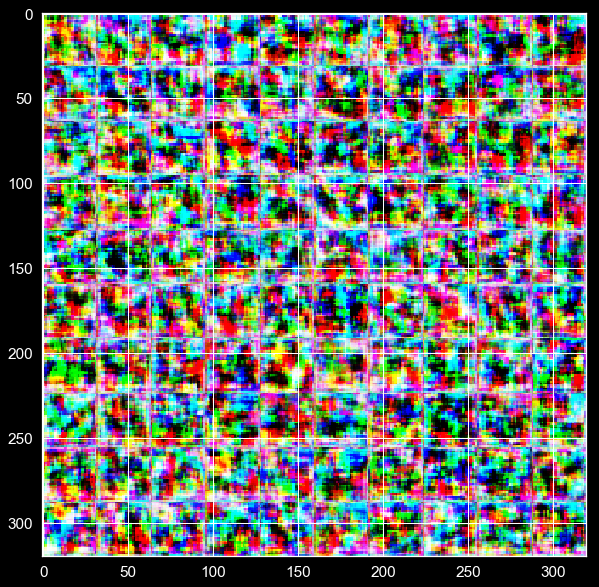

Discriminator loss: 2.34115171432    Generator loss 0.108888320625


In [434]:
for epoch_i in range(num_epochs):
    print("Starting eopch {0}".format(epoch_i))
    
    for step_i in tqdm_notebook(range(num_steps)):
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        
        x_batch = x_train[idx,...]
        
        noise_batch = np.random.normal(size=(batch_size, z_len))
        
        gen_batch = gen_model.predict(noise_batch)
        
        disc_loss_valid = disc_model.train_on_batch(x_batch, valid_)
        disc_loss_fake = disc_model.train_on_batch(gen_batch, fake_)
        disc_loss_list.append(np.mean([disc_loss_valid, disc_loss_fake]))
        
        gen_loss = comb.train_on_batch(noise_batch, valid_)
        gen_loss_list.append(gen_loss)
        
    gen_sample = gen_model.predict(noise_sample)
    
    gen_sample = (gen_sample+1)/2
    
    gen_sample = gen_sample.reshape(10, 10*32, 32, 3)
    gen_sample = gen_sample.transpose((0, 2, 1, 3))
    gen_sample = gen_sample.reshape(10*32, 10*32, 3)
    gen_sample = gen_sample.transpose((1, 0, 2))
    
    plt.clf();
    plt.figure();
    plt.imshow(gen_sample)
    plt.show();
    
    print("Discriminator loss: {0}    Generator loss {1}".format(np.mean(disc_loss_list[-num_steps:]), np.mean(gen_loss_list[-num_steps:])))